In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from rdkit import Chem
import requests
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import DBSCAN

from tkgdti.data.GraphBuilder import GraphBuilder
import os 

from tkgdti.data.utils import get_protein_sequence_uniprot

import re
import pandas as pd

# set seed 
torch.manual_seed(0)
np.random.seed(0)


/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ProtBert; protein similarity protein 

## First, retrieve amino acid sequences... 

In [2]:
root = '../../extdata/relations/'
relnames = os.listdir(root)
GB = GraphBuilder(root=root, relnames=relnames, val_idxs=None, test_idxs=None)
print('building...')
GB.build() 

Node types: ['disease' 'drug' 'gene' 'pathway']
building...


In [3]:
genespace = np.unique(GB.relations[lambda x: x.src_type == 'gene'].src.values.tolist() + GB.relations[lambda x: x.dst_type == 'gene'].dst.values.tolist())
len(genespace)

14304

In [4]:

def parse_fasta_to_dataframe(path):
    """
    Reads a FASTA file from the given path, parses out the organism, gene name,
    and sequence for each entry, and returns a pandas DataFrame.
    """

    # List to hold all records as dictionaries
    records = []
    current_record = None

    # Regex patterns to extract organism and gene name
    organism_pattern = re.compile(r'OS=(.+?)\s+OX=')
    gene_pattern = re.compile(r'GN=(\S+)')

    with open(path, 'r') as fasta_file:
        for line in fasta_file:
            line = line.strip()
            if not line:
                continue  # skip empty lines

            # Check if this line is a new FASTA header
            if line.startswith('>'):
                # If we already have a record built, store it
                if current_record:
                    records.append(current_record)

                # Initialize a new record
                header_line = line[1:].strip()  # remove '>'
                current_record = {
                    'id': header_line.split()[0],  # first token as ID
                    'organism': None,
                    'gene_name': None,
                    'sequence': []
                }

                # Extract organism
                organism_match = organism_pattern.search(header_line)
                if organism_match:
                    current_record['organism'] = organism_match.group(1)

                # Extract gene name
                gene_match = gene_pattern.search(header_line)
                if gene_match:
                    current_record['gene_name'] = gene_match.group(1)

            else:
                # Lines not starting with '>' are part of the sequence
                if current_record is not None:
                    current_record['sequence'].append(line)

        # Append the last record if it exists
        if current_record:
            records.append(current_record)

    # Convert the list of sequence lines into a single string for each record
    for record in records:
        record['sequence'] = ''.join(record['sequence'])

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(records, columns=['id', 'organism', 'gene_name', 'sequence'])
    return df

In [5]:
gene2aa = parse_fasta_to_dataframe('../../data/tkg_raw/UP000005640_9606.fasta')
gene2aa.head()


,id,organism,gene_name,sequence
0,tr|A0A0A0MTA3|A0A0A0MTA3_HUMAN,Homo sapiens,IGKJ5,XITFGQGTRLEIK
1,sp|A6NFQ2|TCAF2_HUMAN,Homo sapiens,TCAF2,MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...
2,sp|A6NJR5|SPDL3_HUMAN,Homo sapiens,None,MQKHYTVAWFLYSAPGVDPSPPCRSLGWKRKKEWSDESEEEPEKEL...
3,sp|A6NKG5|RTL1_HUMAN,Homo sapiens,RTL1,MIEPSEDSFETMMEHKNPSSKQMESSEGSSNTTEATSGSGVRGEAG...
4,sp|A6NL46|YF016_HUMAN,Homo sapiens,None,MRLCLIPWNTTPHRVLPPVVWSAPSRKKPVLSARNSMMFGHLSPVR...


In [6]:
gene2aa = gene2aa[lambda x: x.gene_name.isin(genespace)]
gene2aa = gene2aa.groupby('gene_name').first().reset_index()
print('shape:', gene2aa.shape)
gene2aa.head()

shape: (13023, 4)


,gene_name,id,organism,sequence
0,A1BG,sp|P04217|A1BG_HUMAN,Homo sapiens,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
1,A1CF,sp|Q9NQ94|A1CF_HUMAN,Homo sapiens,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...
2,A2M,sp|P01023|A2MG_HUMAN,Homo sapiens,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...
3,A3GALT2,sp|U3KPV4|A3LT2_HUMAN,Homo sapiens,MALKEGLRAWKRIFWRQILLTLGLLGLFLYGLPKFRHLEALIPMGV...
4,A4GALT,sp|Q9NPC4|A4GAT_HUMAN,Homo sapiens,MSKPPDLLLRLLRGAPRQRVCTLFIIGFKFTFFVSIMIYWHVVGEP...


In [7]:
gene2aa.to_csv('../../extdata/meta/gene2aa.csv', index=False)

## load transformer and embed amino acid sequences...

In [8]:
MAX_LEN = 750
batch_size = 256
SIM_QUANTILE = 0.999

In [9]:
model_name = "Rostlab/prot_bert"

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model = AutoModel.from_pretrained(model_name)

In [10]:
aas = gene2aa.sequence.values

In [11]:
def prepare_sequence(seq):
    seq = ' '.join(list(seq))
    return f"[CLS] {seq} [SEP]"

sequences_prepared = [prepare_sequence(seq) for seq in aas]

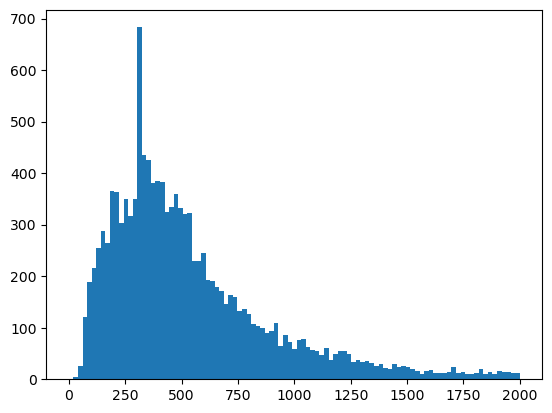

In [12]:
plt.figure()
plt.hist([len(aa) for aa in aas], bins=np.linspace(0,2000,100))
plt.show()

In [13]:
inputs = tokenizer(
    sequences_prepared,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=MAX_LEN  # Adjust as needed
)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

outputs = []
for i in range(0, len(inputs['input_ids']), batch_size):
    print(f'progress: {i}/{len(inputs["input_ids"])}', end='\r')
    batch_inputs = {key: value[i:i+batch_size] for key, value in inputs.items()}
    with torch.no_grad():
        batch_outputs = model(**batch_inputs)
    outputs.append(batch_outputs.last_hidden_state[:, 0, :].cpu())
    torch.cuda.empty_cache()
    
outputs = torch.cat(outputs, dim=0)


In [15]:
z_prot = outputs.cpu().numpy()

In [16]:
z_prot.shape

(13023, 1024)

In [17]:
# Initialize an empty list to store the combined embeddings
res = {'drug_i': [], 'drug_j': [], 'cos_sim': []}

# Iterate over the upper triangle indices
for i in range(len(aas)):
        print(f'progress: {i}/{len(aas)}', end='\r')

        res['drug_i'] += [i]*len(aas)
        res['drug_j'] += [j for j in range(len(aas))] 
        res['cos_sim'] += cosine_similarity(z_prot[[i]], z_prot).ravel().tolist()

res = pd.DataFrame(res)

aa2gene = {aa:g for aa,g in zip(gene2aa.sequence, gene2aa.gene_name)}

# no simple structure, we'll just use the cosine similarity
res = res.assign(gene_i = [aa2gene[aas[i]] for i in res['drug_i']],
                 gene_j = [aa2gene[aas[j]] for j in res['drug_j']])

res.head() 

,drug_i,drug_j,cos_sim,gene_i,gene_j
0,0,0,1.000000,A1BG,A1BG
1,0,1,0.912154,A1BG,A1CF
2,0,2,0.932453,A1BG,A2M
3,0,3,0.963067,A1BG,A3GALT2
4,0,4,0.903232,A1BG,A4GALT


In [18]:
res = res[lambda x: x.gene_i != x.gene_j]

In [19]:
cos_sim_thresh = np.quantile(res['cos_sim'], SIM_QUANTILE)
print(f'Cosine similarity threshold: {cos_sim_thresh:.4f}')
res = res.assign(is_similar=res['cos_sim'] > cos_sim_thresh)

Cosine similarity threshold: 0.9990


In [20]:
#res.to_csv('../../extdata/meta/protbert_prot_prot_similarity.csv', index=False)

In [21]:
sim_relations = res[res['is_similar']]
sim_relations = sim_relations[['gene_i', 'gene_j']].rename({'gene_i': 'src', 'gene_j': 'dst'}, axis=1)
sim_relations = sim_relations.assign(src_type = 'gene', dst_type = 'gene', relation = 'protbert_similarity')
sim_relations.to_csv('../../extdata/relations/protbert__gene_gene_similarity.csv', index=False)

In [22]:
print(sim_relations.shape)
sim_relations.head() 

(169576, 5)


,src,dst,src_type,dst_type,relation
13423,A1CF,AKAP8L,gene,gene,protbert_similarity
13809,A1CF,ARNT2,gene,gene,protbert_similarity
15362,A1CF,CPEB1,gene,gene,protbert_similarity
15777,A1CF,DEAF1,gene,gene,protbert_similarity
16403,A1CF,EPB41L4B,gene,gene,protbert_similarity
